# Classificação de imagens de satélite do cerrado brasileiro

## Libraries and dataset import

In [1]:
import torch
from PIL import Image
import io
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import random
import cv2
from PIL import ImageDraw
from math import ceil, floor
from statistics import median
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
dataset = load_dataset("jonathan-roberts1/Brazilian_Cerrado-Savanna_Scenes")

Found cached dataset parquet (/home/beto_/.cache/huggingface/datasets/jonathan-roberts1___parquet/jonathan-roberts1--Brazilian_Cerrado-Savanna_Scenes-519496fe665653ae/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

## Funções de pré-processamento

In [5]:
class RGB:
  def __init__(self, r, g, b):
    self.r = 255 if r > 255 else (0 if r < 0 else int(r))
    self.g = 255 if g > 255 else (0 if g < 0 else int(g))
    self.b = 255 if b > 255 else (0 if b < 0 else int(b))

In [6]:
class HSB:
  def __init__(self, h, s, b):
    self.h = 360 if h > 360 else (0 if h < 0 else h)
    self.s = 1 if s > 1 else (0 if s < 0 else s)
    self.b = 1 if b > 1 else (0 if b < 0 else b)

In [7]:
def RGB_HSB(rgb: RGB):
  # normalize red, green, and blue values
  r = rgb.r / 255.0
  g = rgb.g / 255.0
  b = rgb.b / 255.0

  max_val = max(r, g, b)
  min_val = min(r, g, b)

  if max_val == min_val:
    h = 0
  elif max_val == r and g >= b:
    h = 60*(g - b)/(max_val - min_val)
  elif max_val == r and g < b:
    h = 60*(g - b)/(max_val - min_val) + 360
  elif max_val == g:
    h = 60*(b - r)/(max_val - min_val) + 120
  elif max_val == b:
    h = 60*(r - g)/(max_val - min_val) + 240

  s = 0 if max_val == 0 else 1.0 - min_val / max_val

  return HSB(h, s, max_val)

In [8]:
def HSB_RGB(hsb: HSB):
  r = 0
  g = 0
  b = 0

  if hsb.s == 0:
    r = g = b = hsb.b
  else:
    sector_pos = hsb.h/60.0
    sector_number = int(sector_pos)
    fractional_sector = sector_pos - sector_number

    p = hsb.b*(1.0 - hsb.s)
    q = hsb.b*(1.0 - (hsb.s*fractional_sector))
    t = hsb.b*(1.0 - (hsb.s*(1 - fractional_sector)))

    if sector_number == 0 or sector_number == 6:
      r = hsb.b
      g = t
      b = p
    elif sector_number == 1:
      r = q
      g = hsb.b
      b = p
    elif sector_number == 2:
      r = p
      g = hsb.b
      b = t
    elif sector_number == 3:
      r = p
      g = q
      b = hsb.b
    elif sector_number == 4:
      r = t
      g = p
      b = hsb.b
    elif sector_number == 5:
      r = hsb.b
      g = p
      b = q

  return RGB(
    int(r*255.0 + 0.5),
    int(g*255.0 + 0.5),
    int(b*255.0 + 0.5)
  )

In [9]:
def get_HSB_pixels(image: Image):
  hsb_pixels = []
  for pixel in image.getdata():
    hsb = RGB_HSB(RGB(pixel[0], pixel[1], pixel[2]))
    hsb_pixels.append((hsb.h, hsb.s, hsb.b))

  return hsb_pixels

In [10]:
def mult_filter_b(image, factor):
  hsb_pixels = get_HSB_pixels(image)

  rgb_pixels = []
  for pixel in hsb_pixels:
    rgb = HSB_RGB(HSB(pixel[0], pixel[1], factor*pixel[2]))
    rgb_pixels.append((rgb.r, rgb.g, rgb.b))

  # Create and save a new image with RGB pixels
  rgb_image = Image.new('RGB', image.size)
  rgb_image.putdata(rgb_pixels)
  return rgb_image

In [11]:
def expand_histogram(image: Image, L):
  min_val_r = 255
  min_val_g = 255
  min_val_b = 255
  max_val_r = 0
  max_val_g = 0
  max_val_b = 0
  for pixel in image.getdata():
    if pixel[0] < min_val_r:
      min_val_r = pixel[0]
    if pixel[1] < min_val_g:
      min_val_g = pixel[1]
    if pixel[2] < min_val_b:
      min_val_b = pixel[2]
    if pixel[0] > max_val_r:
      max_val_r = pixel[0]
    if pixel[1] > max_val_g:
      max_val_g = pixel[1]
    if pixel[2] > max_val_b:
      max_val_b = pixel[2]

  expanded_pixels = []
  for pixel in image.getdata():
    if min_val_r != max_val_r:
      r = int((pixel[0] - min_val_r)/(max_val_r - min_val_r)*(L - 1) + 0.5)
    else:
      r = pixel[0]
    if min_val_g != max_val_g:
      g = int((pixel[1] - min_val_g)/(max_val_g - min_val_g)*(L - 1) + 0.5)
    else:
      g = pixel[1]
    if min_val_b != max_val_b:
      b = int((pixel[2] - min_val_b)/(max_val_b - min_val_b)*(L - 1) + 0.5)
    else:
      b = pixel[2]
    rgb = RGB(r, g, b)
    expanded_pixels.append((rgb.r, rgb.g, rgb.b))

  # Create and save a new image with RGB pixels
  expanded_image = Image.new('RGB', image.size)
  expanded_image.putdata(expanded_pixels)
  return expanded_image

In [12]:
def median_filter(image: Image, m=3, n=3):
  image_c, image_r = image.size

  # Consider the matrix shape for iterating through pixels
  # Choose pivot position: for odd values of length, select the center position;
  #   for even values of length, select the position at the left of the center
  pivot_i = ceil(m/2) - 1
  pivot_j = ceil(n/2) - 1
  start_i = pivot_i
  stop_i = image_r - floor(m/2)
  start_j = pivot_j
  stop_j = image_c - floor(n/2)
  start_delta_i = -pivot_i
  stop_delta_i = floor(m/2) + 1
  start_delta_j = -pivot_j
  stop_delta_j = floor(n/2) + 1

  median_pixels = []
  for i in range(start_i, stop_i):
    for j in range(start_j, stop_j):
      r_vals = []
      g_vals = []
      b_vals = []
      for di in range(start_delta_i, stop_delta_i):
        for dj in range(start_delta_j, stop_delta_j):
          r_vals.append(image.getdata()[(i + di)*image_c + (j + dj)][0])
          g_vals.append(image.getdata()[(i + di)*image_c + (j + dj)][1])
          b_vals.append(image.getdata()[(i + di)*image_c + (j + dj)][2])
      rgb = RGB(median(r_vals), median(g_vals), median(b_vals))
      median_pixels.append((rgb.r, rgb.g, rgb.b))

  median_image = Image.new('RGB', (stop_j - start_j, stop_i - start_i))
  median_image.putdata(median_pixels)
  return median_image

In [13]:
image = dataset['train']['image'][10]
image_bright = mult_filter_b(image, 1.5)
image_expanded = expand_histogram(image, 255)
image_median = median_filter(image)

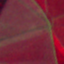

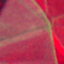

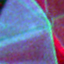

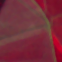

In [14]:
display(image)
display(image_bright)
display(image_expanded)
display(image_median)

In [18]:
image_datasets = []
dataset_names = []
for apply_brightness in [True, False]:
  for apply_expansion in [True, False]:
    for apply_median in [True, False]:
      new_dataset = dataset['train']['image'].copy()
      if apply_brightness == True:
        for i in range(len(new_dataset)):
          new_dataset[i] = mult_filter_b(new_dataset[i], 1.5)
      if apply_expansion == True:
        for i in range(len(new_dataset)):
          new_dataset[i] = expand_histogram(new_dataset[i], 255)
      if apply_median == True:
        for i in range(len(new_dataset)):
          new_dataset[i] = median_filter(new_dataset[i])
      image_datasets.append(new_dataset)
      dataset_names.append(f'bright-{apply_brightness},expansion-{apply_expansion},median-{apply_median}')

## Funções de data augmentation

In [173]:
# Recebe um dataset e cria um banco de imagens augmentadas dele
def data_augmentation(dataset):
    augmented_images = []
    augmented_labels = []
    for image, label in zip(dataset['image'], dataset['label']):
        # Converte a imagem para formato numpy
        image_array = np.array(image)

        # Imagem Original
        image_original = image.copy()
        augmented_images.append(image_original)
        augmented_labels.append(label)

        # Aplica o flip horizontal
        image_flip_horizontal = cv2.flip(image_array, 1)
        augmented_images.append(Image.fromarray(image_flip_horizontal))
        augmented_labels.append(label)

        # Aplica o flip vertical
        image_flip_vertical = cv2.flip(image_array, 0)
        augmented_images.append(Image.fromarray(image_flip_vertical))
        augmented_labels.append(label)

        # Rotação 90°
        image_rotated_90 = image.rotate(90)
        augmented_images.append(image_rotated_90)
        augmented_labels.append(label)

        # Rotação 180°
        image_rotated_180 = image.rotate(180)
        augmented_images.append(image_rotated_180)
        augmented_labels.append(label)

        # Rotação 270°
        image_rotated_270 = image.rotate(270)
        augmented_images.append(image_rotated_270)
        augmented_labels.append(label)

        # Rotação 90° em imagem flipada na horizontal
        image_flipped_rotated_90 = Image.fromarray(image_flip_horizontal).rotate(90)
        augmented_images.append(image_flipped_rotated_90)
        augmented_labels.append(label)

        # Rotação 180° em imagem flipada na horizontal
        image_flipped_rotated_180 = Image.fromarray(image_flip_horizontal).rotate(180)
        augmented_images.append(image_flipped_rotated_180)
        augmented_labels.append(label)

        # Rotação 270° em imagem flipada na horizontal
        image_flipped_rotated_270 = Image.fromarray(image_flip_horizontal).rotate(270)
        augmented_images.append(image_flipped_rotated_270)
        augmented_labels.append(label)

        # Random erasing
        image_random_erased = image.copy()
        draw = ImageDraw.Draw(image_random_erased)

        tamanho_quadrado = 10
        largura, altura = image_random_erased.size


        x1 = random.randint(0, largura - tamanho_quadrado)
        y1 = random.randint(0, altura - tamanho_quadrado)

        x2 = x1 + tamanho_quadrado
        y2 = y1 + tamanho_quadrado

        draw.rectangle([x1, y1, x2, y2], fill = "black")
        augmented_images.append(image_random_erased)
        augmented_labels.append(label)

    augmented_dataset = {'image': augmented_images, 'label': augmented_labels}
    return augmented_dataset

In [174]:
# Recebe o dataset completo e faz o balanceamento de classes por meio de data augmentation
def balance_data(complete_dataset, n_classes):

    df = pd.DataFrame(complete_dataset['label'],columns = ['label'])
    class_datasets = []
    for label in range(n_classes):
        idxs_labels = df[df['label'] == label].index
        images = [complete_dataset['image'][i] for i in idxs_labels]
        labels = [complete_dataset['label'][i] for i in idxs_labels]
        class_datasets.append({'image': images, 'label': labels})

    max_len = max([len(dataset['image']) for dataset in class_datasets])
    balanced_data = []
    for dataset in class_datasets:
        if len(dataset['image']) < max_len:
            pool = data_augmentation(dataset)
            if len(pool['image']) > max_len - len(dataset['image']):
                test_size = (max_len - len(dataset['image']))/len(pool['image'])
                _, selected_x, _, selected_y = train_test_split(pool['image'], pool['label'], test_size=test_size)
            else:
                selected_x, selected_y = pool['image'], pool['label']

            balanced_data.append({'image': dataset['image'] + selected_x, 'label': dataset['label'] + selected_y})
        else:
            balanced_data.append(dataset)

    augmented_dataset = {'image':[], 'label':[]}
    for dataset in balanced_data:
        for key, value in dataset.items():
            augmented_dataset[key].extend(value)
    
    return augmented_dataset

## Model Training

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_list, label_list, transform=None):
        self.image_list = image_list
        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        image = self.image_list[idx]
        label = self.label_list[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [175]:
# Fine-tuning da convnet
def finetune_model(model, train_loader, val_loader, num_epochs, device):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

        scheduler.step()

        # Validação a cada época
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
    
    print(f'Validation Accuracy: {accuracy:.4f}')

    torch.save(model.state_dict(), 'fine_tuned_model.pth')

    return model

In [ ]:
# Treinamento do modelo
for i in range(len(image_datasets)):
    
    x_train, x_test, y_train, y_test = train_test_split(image_datasets[i], dataset['train']['label'], test_size=0.3, random_state=42, stratify=dataset['train']['label'])
    train_dataset = {'image': x_train, 'label': y_train}
    test_dataset = {'image': x_test, 'label': y_test}

    train_dataset_torched = CustomDataset(train_dataset['image'],train_dataset['label'],transform)
    test_dataset_torched = CustomDataset(test_dataset['image'],test_dataset['label'],transform)

    batch_size = 32
    train_loader = DataLoader(train_dataset_torched, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(test_dataset_torched, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = models.efficientnet_b0(pretrained=True)

    num_classes = 4
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 20 

    print(dataset_names[i])
    model = finetune_model(model, train_loader, val_loader, num_epochs, device)
    print('------------------------')

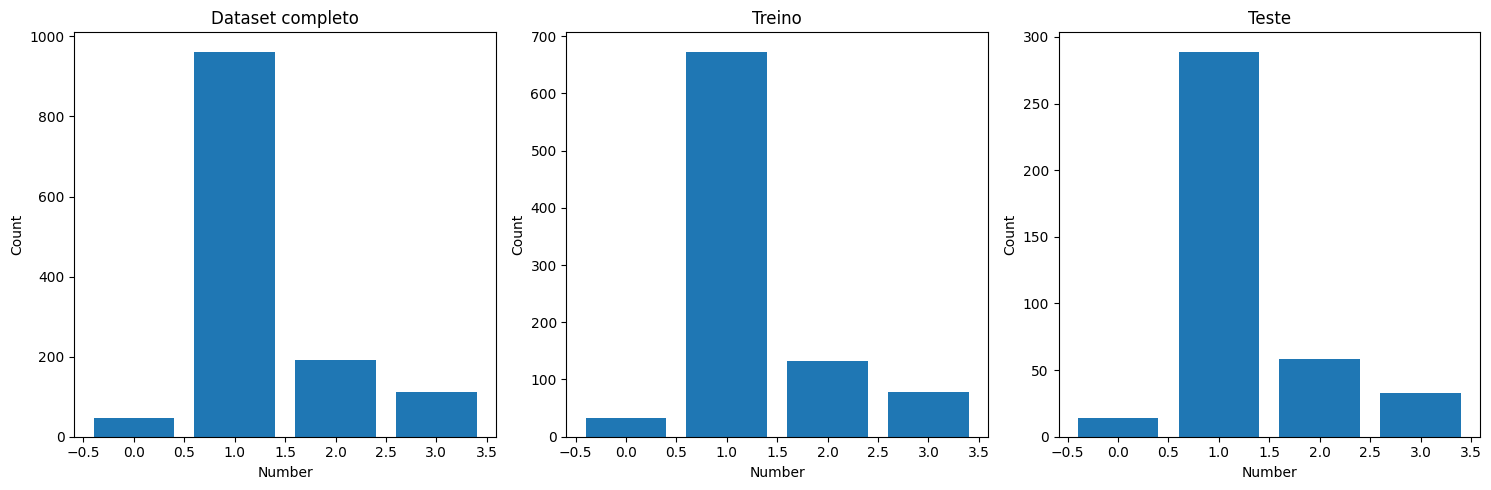

In [20]:
def count_occurrences(arr):
    return dict(Counter(arr))

counts1 = count_occurrences(dataset['train']['label'])
counts2 = count_occurrences(y_train)
counts3 = count_occurrences(y_test)

sorted_counts1 = dict(sorted(counts1.items()))
sorted_counts2 = dict(sorted(counts2.items()))
sorted_counts3 = dict(sorted(counts3.items()))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].bar(sorted_counts1.keys(), sorted_counts1.values())
axs[0].set_title('Dataset completo')
axs[0].set_xlabel('Number')
axs[0].set_ylabel('Count')

axs[1].bar(sorted_counts2.keys(), sorted_counts2.values())
axs[1].set_title('Treino')
axs[1].set_xlabel('Number')
axs[1].set_ylabel('Count')

axs[2].bar(sorted_counts3.keys(), sorted_counts3.values())
axs[2].set_title('Teste')
axs[2].set_xlabel('Number')
axs[2].set_ylabel('Count')

plt.tight_layout()

plt.show()

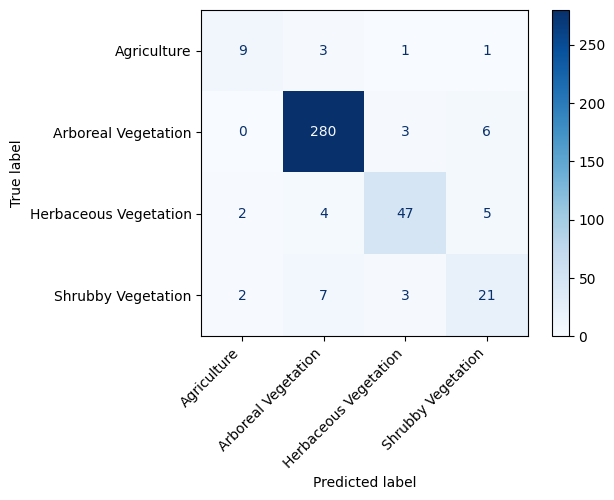

In [187]:
model.eval() 
with torch.no_grad():
    y_pred = []
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend([int(x) for x in predicted])

cm = confusion_matrix(y_test, y_pred)

class_labels = ['Agriculture', 'Arboreal Vegetation', 'Herbaceous Vegetation', 'Shrubby Vegetation']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=45, ha='right') 

plt.gcf().subplots_adjust(bottom=0.2)

plt.show()

## Augment model

In [168]:
x_train, x_test, y_train, y_test = train_test_split(image_datasets[7], dataset['train']['label'], test_size=0.3, random_state=42, stratify=dataset['train']['label'])
train_dataset = {'image': x_train, 'label': y_train}
test_dataset = {'image': x_test, 'label': y_test}
augmented_train_dataset = balance_data(train_dataset,4)

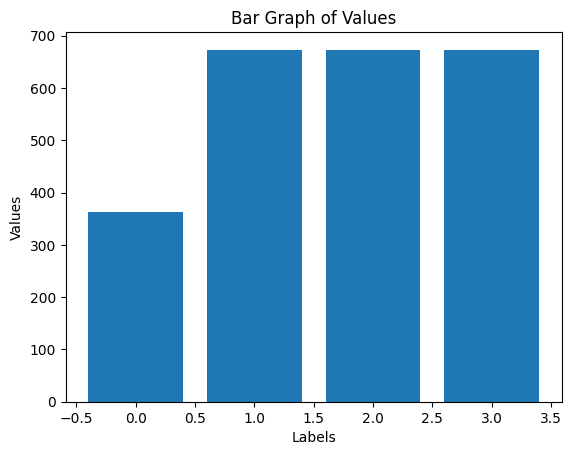

In [181]:
counts2 = count_occurrences(augmented_train_dataset['label'])

sorted_counts2 = dict(sorted(counts2.items()))
labels, values = zip(*sorted_counts2.items())

plt.bar(labels, values)

plt.xlabel('Classes')
plt.ylabel('Values')
plt.title('Contagem de imagens por classe')

# Display the plot
plt.show()

In [189]:
train_dataset_torched = CustomDataset(augmented_train_dataset['image'],augmented_train_dataset['label'],transform)
test_dataset_torched = CustomDataset(test_dataset['image'],test_dataset['label'],transform)

batch_size = 32
train_loader = DataLoader(train_dataset_torched, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(test_dataset_torched, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

model = models.efficientnet_b0(pretrained=True)

num_classes = 4 
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20

model = finetune_model(model, train_loader, val_loader, num_epochs, device)

Validation Accuracy: 0.9213


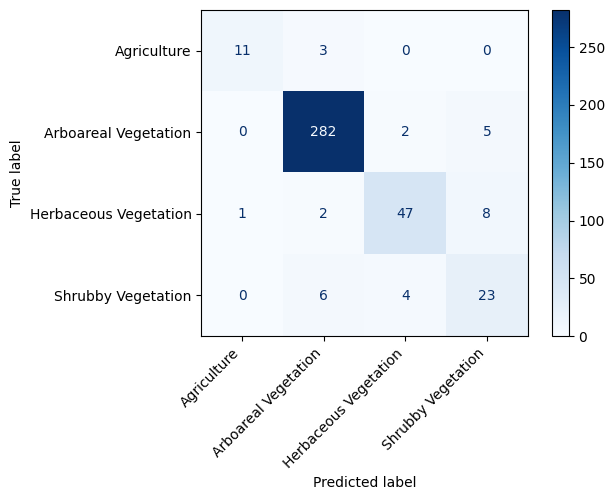

In [191]:
model.eval() 
with torch.no_grad():
    y_pred = []
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend([int(x) for x in predicted])

cm = confusion_matrix(y_test, y_pred)

class_labels = ['Agriculture', 'Arboreal Vegetation', 'Herbaceous Vegetation', 'Shrubby Vegetation']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=45, ha='right')

plt.gcf().subplots_adjust(bottom=0.2)

plt.show()